In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import recall_score, precision_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV

import joblib

https://www.kaggle.com/volodymyrgavrysh/bank-marketing-campaigns-dataset

# Features Description

### bank client data:
- __age__
- __job__ : type of job (categorical: "admin.","blue-collar","entrepreneur",...,"unknown")
- __marital__ : marital status (categorical: "divorced","married","single","unknown")
- __education__ : (categorical: "illiterate",...,"university.degree","unknown")
- __default__: has credit in default? (categorical: "no","yes","unknown")
- __housing__: has housing loan? (categorical: "no","yes","unknown")
- __loan__: has personal loan? (categorical: "no","yes","unknown")
    
### related with the last contact of the current campaign:
- __contact__: contact communication type (categorical: "cellular","telephone")
- __month__: last contact month of year (categorical: "jan", …, "nov", "dec")
- __dayofweek__: last contact day of the week (categorical: "mon","tue",...)
- __duration__: last contact duration, in seconds (numeric).
    - __Important note__: this attribute highly affects the output target (e.g., if duration=0 then y="no"). , Can not get this feature before the campaign

### other attributes:
- __campaign__: number of contacts performed during this campaign and for this client (numeric, includes last contact)
    - __Important note__: Can not get this feature before the campaign
- __pdays__: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- __previous__: number of contacts performed before this campaign and for this client (numeric)
- __poutcome__: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")

### social and economic context attributes
- __emp.var.rate__: employment variation rate - quarterly indicator (numeric)
- __cons.price.idx__: consumer price index - monthly indicator (changes in the price level of a weighted average __market basket__ of consumer goods and services purchased by households, affect inflation (numeric))
- __cons.conf.idx__: consumer confidence index - monthly indicator (degree of __consumers optimism__ are expressing through their activities of savings and spending. affect consumer behavior (numeric))
- __euribor3m__: euribor 3 month rate - daily indicator (Euribor (euro interbank offered rate) (numeric))
- __nr.employed__: number of employees - quarterly indicator (Number of employed persons for a quarter (numeric))

### Output variable (desired target):
- __y__ - has the client subscribed a term deposit? (binary: "yes","no")

# GOALS 

1. __Reduce False Positive__ 
2. __Increase Precision for y='yes'__

# DATA PREPROCESSING

In [2]:
## Read data from csv

df = pd.read_csv('bank-additional-full.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
# change value format in education column

df.education = df.education.apply(lambda x : x.replace(".", " "))

In [4]:
# drop columns that we can not get if we use the model before the campaign

df_1 = df.drop(columns=['duration', 'campaign'
#                         , 'emp.var.rate', 'nr.employed', 'day_of_week', 'housing'
                       ])

In [5]:
# showing dataframe

df_1.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic 4y,no,no,no,telephone,may,mon,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high school,unknown,no,no,telephone,may,mon,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high school,no,yes,no,telephone,may,mon,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic 6y,no,no,no,telephone,may,mon,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high school,no,no,yes,telephone,may,mon,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
# change target column values to numeric value

df_1['y'][df_1['y'] == 'no'] = 0
df_1['y'][df_1['y'] == 'yes'] = 1

In [7]:
# check the value in target columns

df_1['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

In [8]:
# change the value's type into integer

df_1['y'] = df_1['y'].astype('int')

## Data Imbalance Check

In [14]:
# check distribution of the target column values in percentage

round(df_1['y'].value_counts()/len(df_1)*100, 2)

0    88.73
1    11.27
Name: y, dtype: float64

## Features Engineering

Do the __Scaling__ for numerical columns (Robust Scaling) in Pipeline

1. __Label Encoding__ for education column

In [17]:
# Label encoding using map

df_1['education'] = df_1['education'].map({'basic 4y':1
                              , 'basic 6y':2
                              , 'basic 9y' :3
                              , "high school":4
                              , "university degree":5
                              , 'professional course':6
                              , 'illiterate':0
                              , 'unknown':0
                             })

## Splitting Data

In [654]:
# seperate the columns into X and Y

X = df_1.drop(columns='y')
y = df_1['y']

In [19]:
# data splitting

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.20, random_state=42)

## Over Sampling

Do oversampling method (because the data is imbalance) __only__ for train data

In [20]:
# make data frame from train data

df_train = pd.concat([X_train,y_train], axis=1)

In [21]:
# show df_train

df_train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
25611,49,blue-collar,married,3,unknown,no,no,cellular,nov,wed,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8,0
26010,37,entrepreneur,married,5,no,no,no,telephone,nov,wed,999,1,failure,-0.1,93.200,-42.0,4.120,5195.8,0
40194,78,retired,married,1,no,no,no,cellular,jul,mon,999,0,nonexistent,-1.7,94.215,-40.3,0.870,4991.6,1
297,36,admin.,married,5,no,yes,no,telephone,may,mon,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
36344,59,retired,divorced,5,no,no,no,cellular,jun,tue,999,0,nonexistent,-2.9,92.963,-40.8,1.262,5076.2,0


In [22]:
# check data imbalance in df_train

df_train['y'].value_counts()

0    29238
1     3712
Name: y, dtype: int64

In [23]:
non_default = df_train[df_train['y'] == 0] # majority class

In [24]:
default = df_train[df_train['y'] == 1] # minority class

In [25]:
# Oversampling/Upsampling with resample method

default_oversample = resample(default, 
                           replace = True, 
                           n_samples = len(non_default),
                           random_state=42)

In [26]:
# make data frame for oversampling data

df_OverSample= pd.concat([non_default, default_oversample])

In [27]:
# checking data imbalance in df_oversample

df_OverSample['y'].value_counts()

1    29238
0    29238
Name: y, dtype: int64

In [28]:
# Separate data X and Y for Oversample Data fram

X_train_OS = df_OverSample.drop(columns='y')
y_train_OS = df_OverSample['y']

# MODELLING

## Pipeline

we used pipeline method for modelling

In [29]:
# define the numeric columns and categoric columns from the dataset

num_columns = ['age', 'education', 'pdays', 'previous', 'cons.price.idx', 'cons.conf.idx', 'euribor3m'
               , 'nr.employed', 'emp.var.rate'
              ]

cat_columns = [i for i in df_1.columns if (i not in num_columns) & (i!='y')]

In [30]:
# create pipeline and model

numeric_pipeline = Pipeline([
    ('scaler', RobustScaler()),
#     ('poly', PolynomialFeatures(degree=2, include_bias=False)),
#     ('power', PowerTransformer(method='yeo-johnson'))
])

categoric_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns),
    ('categorical', categoric_pipeline, cat_columns)
])

pipe_LR = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression())
])

pipe_KNN = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier())
])

pipe_SVM = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=600))
])

pipe_DT = Pipeline([
    ('prep', preprocessor),
    ('algo', DecisionTreeClassifier(random_state=42))
])

pipe_RF = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(random_state=42))
])

pipe_XGB = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier())
])

## Def Function for Evaluation Metrix

create a `def` function for evaluation metrix after modelling

In [31]:
# def function for each model evaluation matrix

def conf_mat (Model, X_train, X_test, y_train, y_test,Nama):
    y_pred_test = Model.predict(X_test)
    cm_test = confusion_matrix(y_test, y_pred_test, labels=[1,0])
    df_test = pd.DataFrame(cm_test, index = ['Akt1', 'Akt0'], columns=['Pred1', 'Pred0'])
    print( 'Classification report data TEST ' + Nama + '\n\n', classification_report(y_test, y_pred_test))
    print('\nROC AUC test :', round(roc_auc_score(y_test, y_pred_test), 2), '\n')
    print('\nConfusion matrix data test ' + Nama + '\n\n')
    print(df_test)
    print('='*100)
    y_pred_train = Model.predict(X_train)
    cm_train = confusion_matrix(y_train, y_pred_train, labels=[1,0])
    df_train = pd.DataFrame(cm_train, index = ['Akt1', 'Akt0'], columns=['Pred1', 'Pred0'])
    print( 'Classification report data TRAIN ' + Nama + '\n\n', classification_report(y_train, y_pred_train))
    print('\nROC AUC train :', round(roc_auc_score(y_train, y_pred_train), 2), '\n')
    print('\nConfusion matrix data train ' + Nama + '\n\n')
    print(df_train)

In [32]:
# def function to compare the evaluation matrix for some models

def prec_rec (Model, X_test, y_test, Nama):
    data = {}
    prec = []
    rec = []
    for i in Model :
        y_pred_ts = i.predict(X_test)
        precision = precision_score(y_test, y_pred_ts)
        recall = recall_score(y_test, y_pred_ts)
        prec.append(precision)
        rec.append(recall)
    for j in range (len(Nama)):
        data[Nama[j]] = [prec[j], rec[j]]
    
    df = pd.DataFrame(data, index=['Precison', 'Recall'])
    return df

## Model fitting

__Logistic Regression__

In [33]:
# Logistic regression base model fitting

pipe_LR.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'education', 'pdays',
                                                   'previous', 'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed',
                                                   'emp.var.rate']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'l

In [34]:
# evaluation matrix of Logistic regression base model

conf_mat(pipe_LR, X_train_OS, X_test, y_train_OS, y_test, 'LR Base')

Classification report data TEST LR Base

               precision    recall  f1-score   support

           0       0.95      0.85      0.90      7310
           1       0.36      0.65      0.46       928

    accuracy                           0.83      8238
   macro avg       0.65      0.75      0.68      8238
weighted avg       0.88      0.83      0.85      8238


ROC AUC test : 0.75 


Confusion matrix data test LR Base


      Pred1  Pred0
Akt1    599    329
Akt0   1082   6228
Classification report data TRAIN LR Base

               precision    recall  f1-score   support

           0       0.69      0.85      0.76     29238
           1       0.80      0.62      0.70     29238

    accuracy                           0.73     58476
   macro avg       0.75      0.73      0.73     58476
weighted avg       0.75      0.73      0.73     58476


ROC AUC train : 0.73 


Confusion matrix data train LR Base


      Pred1  Pred0
Akt1  18136  11102
Akt0   4411  24827


__K-Nearest Neighbor__

In [35]:
# K-Nearest Neighbor base model fitting

pipe_KNN.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'education', 'pdays',
                                                   'previous', 'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed',
                                                   'emp.var.rate']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'l

In [36]:
# evaluation metrix of K-Nearest Neighbor base model

conf_mat(pipe_KNN, X_train_OS, X_test, y_train_OS, y_test, 'KNN Base')

Classification report data TEST KNN Base

               precision    recall  f1-score   support

           0       0.94      0.81      0.87      7310
           1       0.27      0.57      0.37       928

    accuracy                           0.78      8238
   macro avg       0.60      0.69      0.62      8238
weighted avg       0.86      0.78      0.81      8238


ROC AUC test : 0.69 


Confusion matrix data test KNN Base


      Pred1  Pred0
Akt1    531    397
Akt0   1424   5886
Classification report data TRAIN KNN Base

               precision    recall  f1-score   support

           0       1.00      0.86      0.92     29238
           1       0.87      1.00      0.93     29238

    accuracy                           0.93     58476
   macro avg       0.93      0.93      0.93     58476
weighted avg       0.93      0.93      0.93     58476


ROC AUC train : 0.93 


Confusion matrix data train KNN Base


      Pred1  Pred0
Akt1  29115    123
Akt0   4194  25044


__Support Vector Machine__

In [37]:
# Support Vector Machine base model fitting

pipe_SVM.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'education', 'pdays',
                                                   'previous', 'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed',
                                                   'emp.var.rate']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'l

In [38]:
# Evaluation Matrix of Support Vector Machine base model

conf_mat(pipe_SVM, X_train_OS, X_test, y_train_OS, y_test, 'SVM Base')

Classification report data TEST SVM Base

               precision    recall  f1-score   support

           0       0.35      0.01      0.03      7310
           1       0.09      0.80      0.17       928

    accuracy                           0.10      8238
   macro avg       0.22      0.41      0.10      8238
weighted avg       0.32      0.10      0.04      8238


ROC AUC test : 0.41 


Confusion matrix data test SVM Base


      Pred1  Pred0
Akt1    741    187
Akt0   7208    102
Classification report data TRAIN SVM Base

               precision    recall  f1-score   support

           0       0.07      0.02      0.02     29238
           1       0.45      0.79      0.57     29238

    accuracy                           0.40     58476
   macro avg       0.26      0.40      0.30     58476
weighted avg       0.26      0.40      0.30     58476


ROC AUC train : 0.4 


Confusion matrix data train SVM Base


      Pred1  Pred0
Akt1  23095   6143
Akt0  28792    446


__Decision Tree__

In [39]:
# Decision Tree base model fitting

pipe_DT.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'education', 'pdays',
                                                   'previous', 'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed',
                                                   'emp.var.rate']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'l

In [40]:
# Evaluation Matrix of Decision Tree base model

conf_mat(pipe_DT, X_train_OS, X_test, y_train_OS, y_test, 'DT Over Sampling')

Classification report data TEST DT Over Sampling

               precision    recall  f1-score   support

           0       0.92      0.90      0.91      7310
           1       0.31      0.36      0.33       928

    accuracy                           0.84      8238
   macro avg       0.61      0.63      0.62      8238
weighted avg       0.85      0.84      0.84      8238


ROC AUC test : 0.63 


Confusion matrix data test DT Over Sampling


      Pred1  Pred0
Akt1    331    597
Akt0    750   6560
Classification report data TRAIN DT Over Sampling

               precision    recall  f1-score   support

           0       1.00      0.99      0.99     29238
           1       0.99      1.00      0.99     29238

    accuracy                           0.99     58476
   macro avg       0.99      0.99      0.99     58476
weighted avg       0.99      0.99      0.99     58476


ROC AUC train : 0.99 


Confusion matrix data train DT Over Sampling


      Pred1  Pred0
Akt1  29224     14
Akt0  

__Random Forest__

In [41]:
# Random Forest base model fitting

pipe_RF.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'education', 'pdays',
                                                   'previous', 'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed',
                                                   'emp.var.rate']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'l

In [42]:
# Evaluation Matrix of Random Forest base model

conf_mat(pipe_RF, X_train_OS, X_test, y_train_OS, y_test, 'RF Base')

Classification report data TEST RF Base

               precision    recall  f1-score   support

           0       0.93      0.94      0.93      7310
           1       0.45      0.41      0.43       928

    accuracy                           0.88      8238
   macro avg       0.69      0.67      0.68      8238
weighted avg       0.87      0.88      0.87      8238


ROC AUC test : 0.67 


Confusion matrix data test RF Base


      Pred1  Pred0
Akt1    382    546
Akt0    473   6837
Classification report data TRAIN RF Base

               precision    recall  f1-score   support

           0       1.00      0.98      0.99     29238
           1       0.99      1.00      0.99     29238

    accuracy                           0.99     58476
   macro avg       0.99      0.99      0.99     58476
weighted avg       0.99      0.99      0.99     58476


ROC AUC train : 0.99 


Confusion matrix data train RF Base


      Pred1  Pred0
Akt1  29228     10
Akt0    442  28796


__XGBoost__

In [43]:
# XGBoost base model fitting

pipe_XGB.fit(X_train_OS, y_train_OS)

[04:54:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'education', 'pdays',
                                                   'previous', 'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed',
                                                   'emp.var.rate']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'l

In [44]:
# Evaluation Matrix of XGBoost base model

conf_mat(pipe_XGB, X_train_OS, X_test, y_train_OS, y_test, 'XGB Base')

Classification report data TEST XGB Base

               precision    recall  f1-score   support

           0       0.94      0.88      0.91      7310
           1       0.39      0.59      0.47       928

    accuracy                           0.85      8238
   macro avg       0.67      0.74      0.69      8238
weighted avg       0.88      0.85      0.86      8238


ROC AUC test : 0.74 


Confusion matrix data test XGB Base


      Pred1  Pred0
Akt1    552    376
Akt0    870   6440
Classification report data TRAIN XGB Base

               precision    recall  f1-score   support

           0       0.81      0.90      0.85     29238
           1       0.89      0.79      0.84     29238

    accuracy                           0.85     58476
   macro avg       0.85      0.85      0.85     58476
weighted avg       0.85      0.85      0.85     58476


ROC AUC train : 0.85 


Confusion matrix data train XGB Base


      Pred1  Pred0
Akt1  23185   6053
Akt0   2904  26334


### Comparing Base Models's Evaluation Matrix

In [45]:
# showing the precision and recall of all base model

prec_rec ([pipe_LR, pipe_KNN, pipe_SVM, pipe_DT, pipe_RF, pipe_XGB], X_test, y_test, ['LR_Base', 'KNN_Base', 'SVM_Base', 'DT_Base', 'RF_Base', 'XGB_Base'])

,LR_Base,KNN_Base,SVM_Base,DT_Base,RF_Base,XGB_Base
Precison,0.356336,0.271611,0.093219,0.306198,0.446784,0.388186
Recall,0.645474,0.572198,0.798491,0.356681,0.411638,0.594828


_____________

# __HYPERPARAMETER TUNING__

we choose 4 potential models for hyperparameter tuning:
- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost

In [55]:
# define the stratifiedKfold for cross validation in hyperparameter tuning

skf = StratifiedKFold(n_splits=3)

https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

_____________

## HYPERPARAMETER TUNING LOGISTIC REGRESSION

__Default Parameter__
- 'algo__C': 1,
- 'algo__class_weight': None,
- 'algo__fit_intercept': True,
- 'algo__penalty': 'l2'

__1st TUNING__

In [56]:
# define the Logistic regression parameter for the 1st hyperparameter tuning

param_LR = {
    'algo__C' : list(np.logspace(-4,1,10)) + [1.0],
    'algo__class_weight' : [None, {0:.4, 1:.6}, {0:.3, 1:.7}, {0:.2, 1:.8}, {0:.1, 1:.9}],
    'algo__fit_intercept' : [False, True],
    'algo__penalty' : ['l1', 'l2', 'elasticnet', 'none']
}

In [57]:
# using gridsearchcv method for hyperparameter tuning with precision score as a benchmark

LR_GS = GridSearchCV(pipe_LR, param_LR, cv=skf, n_jobs=-1, verbose=1, scoring='precision')

In [58]:
# run hyperparameter tuning

LR_GS.fit(X_train_OS, y_train_OS)

Fitting 3 folds for each of 440 candidates, totalling 1320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1320 out of 1320 | elapsed:  4.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('scaler',
                                                                                          RobustScaler())]),
                                                                         ['age',
                                                                          'education',
                                                                          'pdays',
                                                                          'previous',
                                                                          'cons.price.idx',
                                                                          'cons.conf.idx',
                                                            

In [59]:
# show the best combination of parameter that create the best precision score

LR_GS.best_params_

{'algo__C': 0.0001,
 'algo__class_weight': None,
 'algo__fit_intercept': True,
 'algo__penalty': 'none'}

In [60]:
# Define Logistic regression model after tuning that have the best parameter

LR_Tune = LR_GS.best_estimator_

In [61]:
# run the model

LR_Tune.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'education', 'pdays',
                                                   'previous', 'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed',
                                                   'emp.var.rate']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'l

In [62]:
# evaluation matrix of the model

conf_mat(LR_Tune, X_train_OS, X_test, y_train_OS, y_test, 'LR Tuning 1 best estimator')

Classification report data TEST LR Tuning 1 best estimator

               precision    recall  f1-score   support

           0       0.95      0.85      0.90      7310
           1       0.35      0.64      0.46       928

    accuracy                           0.83      8238
   macro avg       0.65      0.75      0.68      8238
weighted avg       0.88      0.83      0.85      8238


ROC AUC test : 0.75 


Confusion matrix data test LR Tuning 1 best estimator


      Pred1  Pred0
Akt1    595    333
Akt0   1082   6228
Classification report data TRAIN LR Tuning 1 best estimator

               precision    recall  f1-score   support

           0       0.69      0.85      0.76     29238
           1       0.81      0.62      0.70     29238

    accuracy                           0.74     58476
   macro avg       0.75      0.74      0.73     58476
weighted avg       0.75      0.74      0.73     58476


ROC AUC train : 0.74 


Confusion matrix data train LR Tuning 1 best estimator


    

__2nd TUNING__

In [63]:
# define the Logistic regression parameter for the 2nd hyperparameter tuning

param_LR2 = {
    'algo__C' : np.logspace(-6,-3),
    'algo__class_weight' : [None, {0:.4, 1:.6}, {0:.3, 1:.7}, {0:.2, 1:.8}, {0:.1, 1:.9}],
    'algo__fit_intercept' : [False, True],
    'algo__penalty' : ['l1', 'l2', 'elasticnet', 'none']
}

In [64]:
# using gridsearchcv method for hyperparameter tuning with precision score as a benchmark

LR_GS2 = GridSearchCV(pipe_LR, param_LR2, cv=skf, n_jobs=-1, verbose=1, scoring='precision')

In [65]:
# run hyperparameter tuning

LR_GS2.fit(X_train_OS, y_train_OS)

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 16.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('scaler',
                                                                                          RobustScaler())]),
                                                                         ['age',
                                                                          'education',
                                                                          'pdays',
                                                                          'previous',
                                                                          'cons.price.idx',
                                                                          'cons.conf.idx',
                                                            

In [66]:
# show the best combination of parameters that create the best precision score

LR_GS2.best_params_

{'algo__C': 1e-06,
 'algo__class_weight': None,
 'algo__fit_intercept': True,
 'algo__penalty': 'l2'}

In [67]:
# Define Logistic regression model after tuning that have the best parameter

LR_Tune2 = LR_GS2.best_estimator_

In [68]:
LR_Tune2.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'education', 'pdays',
                                                   'previous', 'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed',
                                                   'emp.var.rate']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'l

In [69]:
conf_mat(LR_Tune2, X_train_OS, X_test, y_train_OS, y_test, 'LR Tuning 2 best estimator')

Classification report data TEST LR Tuning 2 best estimator

               precision    recall  f1-score   support

           0       0.91      0.99      0.94      7310
           1       0.65      0.20      0.31       928

    accuracy                           0.90      8238
   macro avg       0.78      0.59      0.63      8238
weighted avg       0.88      0.90      0.87      8238


ROC AUC test : 0.59 


Confusion matrix data test LR Tuning 2 best estimator


      Pred1  Pred0
Akt1    187    741
Akt0    102   7208
Classification report data TRAIN LR Tuning 2 best estimator

               precision    recall  f1-score   support

           0       0.55      0.98      0.71     29238
           1       0.93      0.21      0.34     29238

    accuracy                           0.60     58476
   macro avg       0.74      0.60      0.53     58476
weighted avg       0.74      0.60      0.53     58476


ROC AUC train : 0.6 


Confusion matrix data train LR Tuning 2 best estimator


     

_____________

## HYPERPARAMETER TUNING DECISION TREE

__Default parameter__
- 'algo__max_depth': None
- 'algo__min_samples_leaf': 1
- 'algo__max_features': None
- 'algo__class_weight': None

__1st TUNING__

In [83]:
# define the Decision tree parameter for the 1st hyperparameter tuning

param_DT = {
    'algo__max_depth': list(np.arange(0, 101, 5)) + [None],
    'algo__min_samples_leaf': np.arange(1, 1000, 50),
    'algo__max_features': [None, 0.2, 0.5, 0.8, 1],
    'algo__class_weight': [None, {0:.4, 1:.6}, {0:.3, 1:.7}, {0:.2, 1:.8}]
}

In [84]:
# using randomizedsearchcv method for hyperparameter tuning with precision score as a benchmark

DT_RS = RandomizedSearchCV(pipe_DT, param_DT, cv=skf, n_iter=2000, n_jobs=-1, verbose=1, random_state=42, scoring='precision')

In [85]:
# run hyperparameter tuning

DT_RS.fit(X_train_OS, y_train_OS)

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 12.4min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('scaler',
                                                                                                RobustScaler())]),
                                                                               ['age',
                                                                                'education',
                                                                                'pdays',
                                                                                'previous',
                                                                                'cons.price.idx',
                                                                                'cons.conf.

In [86]:
# show the best combination of parameters that create the best precision score

DT_RS.best_params_

{'algo__min_samples_leaf': 1,
 'algo__max_features': 0.8,
 'algo__max_depth': 95,
 'algo__class_weight': {0: 0.2, 1: 0.8}}

In [87]:
# Define Decision tree model after tuning that have the best parameter

DT_Tune = DT_RS.best_estimator_

In [88]:
DT_Tune.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'education', 'pdays',
                                                   'previous', 'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed',
                                                   'emp.var.rate']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'l

In [89]:
conf_mat(DT_Tune, X_train_OS, X_test, y_train_OS, y_test, 'DT Tuning 1 best estimator')

Classification report data TEST DT Tuning 1 best estimator

               precision    recall  f1-score   support

           0       0.91      0.91      0.91      7310
           1       0.32      0.33      0.33       928

    accuracy                           0.85      8238
   macro avg       0.62      0.62      0.62      8238
weighted avg       0.85      0.85      0.85      8238


ROC AUC test : 0.62 


Confusion matrix data test DT Tuning 1 best estimator


      Pred1  Pred0
Akt1    307    621
Akt0    646   6664
Classification report data TRAIN DT Tuning 1 best estimator

               precision    recall  f1-score   support

           0       1.00      0.98      0.99     29238
           1       0.98      1.00      0.99     29238

    accuracy                           0.99     58476
   macro avg       0.99      0.99      0.99     58476
weighted avg       0.99      0.99      0.99     58476


ROC AUC train : 0.99 


Confusion matrix data train DT Tuning 1 best estimator


    

__2nd TUNING__

In [92]:
# define the Decision tree parameter for the 2nd hyperparameter tuning

param_DT2 = {
    'algo__max_depth': list(np.arange(50, 151, 5)) + [None],
    'algo__min_samples_leaf': np.arange(1, 100, 10),
    'algo__max_features': [None, 0.2, 0.5, 0.8, 1],
    'algo__class_weight': [None, {0:.4, 1:.6}, {0:.3, 1:.7}, {0:.2, 1:.8}]
}

In [96]:
# using randomizedsearchcv method for hyperparameter tuning with precision score as a benchmark

DT_RS2 = RandomizedSearchCV(pipe_DT, param_DT2, cv=skf, n_iter=2000, n_jobs=-1, verbose=1, random_state=42, scoring='precision')

In [97]:
# run hyperparameter tuning

DT_RS2.fit(X_train_OS, y_train_OS)

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 12.2min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('scaler',
                                                                                                RobustScaler())]),
                                                                               ['age',
                                                                                'education',
                                                                                'pdays',
                                                                                'previous',
                                                                                'cons.price.idx',
                                                                                'cons.conf.

In [98]:
# show the best combination of parameters that create the best precision score

DT_RS2.best_params_

{'algo__min_samples_leaf': 1,
 'algo__max_features': 0.8,
 'algo__max_depth': 60,
 'algo__class_weight': {0: 0.2, 1: 0.8}}

In [99]:
# Define Decision tree model after tuning that have the best parameter

DT_Tune2 = DT_RS2.best_estimator_

In [100]:
DT_Tune2.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'education', 'pdays',
                                                   'previous', 'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed',
                                                   'emp.var.rate']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'l

In [101]:
conf_mat(DT_Tune2, X_train_OS, X_test, y_train_OS, y_test, 'DT Tuning 2 best estimator')

Classification report data TEST DT Tuning 2 best estimator

               precision    recall  f1-score   support

           0       0.91      0.91      0.91      7310
           1       0.32      0.33      0.33       928

    accuracy                           0.85      8238
   macro avg       0.62      0.62      0.62      8238
weighted avg       0.85      0.85      0.85      8238


ROC AUC test : 0.62 


Confusion matrix data test DT Tuning 2 best estimator


      Pred1  Pred0
Akt1    307    621
Akt0    646   6664
Classification report data TRAIN DT Tuning 2 best estimator

               precision    recall  f1-score   support

           0       1.00      0.98      0.99     29238
           1       0.98      1.00      0.99     29238

    accuracy                           0.99     58476
   macro avg       0.99      0.99      0.99     58476
weighted avg       0.99      0.99      0.99     58476


ROC AUC train : 0.99 


Confusion matrix data train DT Tuning 2 best estimator


    

_____________

## HYPERPARAMETER TUNING RANDOM FOREST

__Default__
- 'algo__n_estimators': 100,
- 'algo__max_depth': None,
- 'algo__min_samples_leaf': 1,
- 'algo__class_weight': None

__1st TUNING__

In [103]:
# define the Random Forest parameter for the 1st hyperparameter tuning

param_RF = {
    'algo__n_estimators' : np.arange(100, 1000, 100),
    'algo__max_depth' : list(np.arange(10, 100, 10)) + [None],
    'algo__min_samples_leaf' : list(np.arange(10, 100, 10)) + [1],
    'algo__class_weight' : [None, {0:.4, 1:.6}, {0:.3, 1:.7}, {0:.2, 1:.8}, {0:.15, 1: .85}, {0:.1, 1:.9}]
}

In [104]:
# using randomizedsearchcv method for hyperparameter tuning with precision score as a benchmark

RF_RS = RandomizedSearchCV(pipe_RF, param_RF, cv=skf, n_iter=200, n_jobs=-1, verbose=1, random_state=42, scoring='precision')

In [105]:
# run hyperparameter tuning

RF_RS.fit(X_train_OS, y_train_OS)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 155.9min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 176.5min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('scaler',
                                                                                                RobustScaler())]),
                                                                               ['age',
                                                                                'education',
                                                                                'pdays',
                                                                                'previous',
                                                                                'cons.price.idx',
                                                                                'cons.conf.

In [133]:
# show the best combination of parameters that create the best precision score

RF_RS.best_params_

{'algo__n_estimators': 100,
 'algo__min_samples_leaf': 1,
 'algo__max_depth': 90,
 'algo__class_weight': {0: 0.2, 1: 0.8}}

In [134]:
# Define Random Forest model after tuning that have the best parameter

RF_Tune = RF_RS.best_estimator_

In [135]:
RF_Tune.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'education', 'pdays',
                                                   'previous', 'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed',
                                                   'emp.var.rate']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'l

In [136]:
conf_mat(RF_Tune, X_train_OS, X_test, y_train_OS, y_test, 'RF Tuning best estimator')

Classification report data TEST RF Tuning best estimator

               precision    recall  f1-score   support

           0       0.93      0.94      0.93      7310
           1       0.45      0.41      0.43       928

    accuracy                           0.88      8238
   macro avg       0.69      0.67      0.68      8238
weighted avg       0.87      0.88      0.87      8238


ROC AUC test : 0.67 


Confusion matrix data test RF Tuning best estimator


      Pred1  Pred0
Akt1    379    549
Akt0    471   6839
Classification report data TRAIN RF Tuning best estimator

               precision    recall  f1-score   support

           0       1.00      0.98      0.99     29238
           1       0.98      1.00      0.99     29238

    accuracy                           0.99     58476
   macro avg       0.99      0.99      0.99     58476
weighted avg       0.99      0.99      0.99     58476


ROC AUC train : 0.99 


Confusion matrix data train RF Tuning best estimator


      Pred1 

__2nd TUNING__

In [110]:
# define the Random Forest parameter for the 2nd hyperparameter tuning

param_RF2 = {
    'algo__n_estimators' : [10, 20, 30, 50, 80, 100],
    'algo__max_depth' : [None, 1, 3, 5, 8, 10],
    'algo__min_samples_leaf' : [1, 3, 5, 8, 10],
    'algo__class_weight' : [None, {0:.4, 1:.6}, {0:.3, 1:.7}, {0:.2, 1:.8}, {0:.1, 1:.9}]
}

In [111]:
# using randomizedsearchcv method for hyperparameter tuning with precision score as a benchmark

RF_RS2 = RandomizedSearchCV(pipe_RF, param_RF2, cv=skf, n_iter=200, n_jobs=-1, verbose=1, random_state=42, scoring='precision')

In [112]:
# run hyperparameter tuning

RF_RS2.fit(X_train_OS, y_train_OS)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  5.6min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('scaler',
                                                                                                RobustScaler())]),
                                                                               ['age',
                                                                                'education',
                                                                                'pdays',
                                                                                'previous',
                                                                                'cons.price.idx',
                                                                                'cons.conf.

In [137]:
# show the best combination of parameters that create the best precision score

RF_RS2.best_params_

{'algo__n_estimators': 10,
 'algo__min_samples_leaf': 1,
 'algo__max_depth': None,
 'algo__class_weight': {0: 0.3, 1: 0.7}}

In [138]:
# Define Random Forest model after tuning that have the best parameter

RF_Tune2 = RF_RS2.best_estimator_

In [139]:
RF_Tune2.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'education', 'pdays',
                                                   'previous', 'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed',
                                                   'emp.var.rate']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'l

In [140]:
conf_mat(RF_Tune2, X_train_OS, X_test, y_train_OS, y_test, 'RF Tuning 2 best estimator')

Classification report data TEST RF Tuning 2 best estimator

               precision    recall  f1-score   support

           0       0.92      0.94      0.93      7310
           1       0.41      0.36      0.39       928

    accuracy                           0.87      8238
   macro avg       0.67      0.65      0.66      8238
weighted avg       0.86      0.87      0.87      8238


ROC AUC test : 0.65 


Confusion matrix data test RF Tuning 2 best estimator


      Pred1  Pred0
Akt1    334    594
Akt0    473   6837
Classification report data TRAIN RF Tuning 2 best estimator

               precision    recall  f1-score   support

           0       1.00      0.98      0.99     29238
           1       0.98      1.00      0.99     29238

    accuracy                           0.99     58476
   macro avg       0.99      0.99      0.99     58476
weighted avg       0.99      0.99      0.99     58476


ROC AUC train : 0.99 


Confusion matrix data train RF Tuning 2 best estimator


    

__3rd TUNING__

In [117]:
# define the Random Forest parameter for the 3rd hyperparameter tuning

param_RF3 = {
    'algo__n_estimators' : np.arange(60, 150, 20),
    'algo__max_depth' : list(np.arange(50, 150, 20)) + [None],
    'algo__min_samples_leaf' : np.arange(1, 10, 2),
    'algo__class_weight' : [None, {0:.4, 1:.6}, {0:.3, 1:.7}, {0:.2, 1:.8}, {0:.15, 1: .85}]
}

In [118]:
# using randomizedsearchcv method for hyperparameter tuning with precision score as a benchmark

RF_RS3 = RandomizedSearchCV(pipe_RF, param_RF3, cv=skf, n_iter=200, n_jobs=-1, verbose=1, random_state=42, scoring='precision')

In [119]:
# run hyperparameter tuning

RF_RS3.fit(X_train_OS, y_train_OS)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 18.8min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('scaler',
                                                                                                RobustScaler())]),
                                                                               ['age',
                                                                                'education',
                                                                                'pdays',
                                                                                'previous',
                                                                                'cons.price.idx',
                                                                                'cons.conf.

In [141]:
# show the best combination of parameters that create the best precision score

RF_RS3.best_params_

{'algo__n_estimators': 60,
 'algo__min_samples_leaf': 1,
 'algo__max_depth': 90,
 'algo__class_weight': {0: 0.15, 1: 0.85}}

In [142]:
# Define Random Forest model after tuning that have the best parameter

RF_Tune3 = RF_RS3.best_estimator_

In [143]:
RF_Tune3.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'education', 'pdays',
                                                   'previous', 'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed',
                                                   'emp.var.rate']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'l

In [144]:
conf_mat(RF_Tune3, X_train_OS, X_test, y_train_OS, y_test, 'RF Tuning 3 best estimator')

Classification report data TEST RF Tuning 3 best estimator

               precision    recall  f1-score   support

           0       0.92      0.93      0.93      7310
           1       0.43      0.39      0.41       928

    accuracy                           0.87      8238
   macro avg       0.68      0.66      0.67      8238
weighted avg       0.87      0.87      0.87      8238


ROC AUC test : 0.66 


Confusion matrix data test RF Tuning 3 best estimator


      Pred1  Pred0
Akt1    366    562
Akt0    479   6831
Classification report data TRAIN RF Tuning 3 best estimator

               precision    recall  f1-score   support

           0       1.00      0.98      0.99     29238
           1       0.98      1.00      0.99     29238

    accuracy                           0.99     58476
   macro avg       0.99      0.99      0.99     58476
weighted avg       0.99      0.99      0.99     58476


ROC AUC train : 0.99 


Confusion matrix data train RF Tuning 3 best estimator


    

_____________

## HYPERPARAMETER TUNING XGB

__DEFAULT PARAMETER__

1. 'algo__n_estimators': 100,
2. 'algo__max_depth': 6,
3. 'algo__learning_rate': 0.300000012,
4. 'algo__gamma': 0,
5. 'algo__colsample_bytree': 1,
6. 'algo__subsample': 1,
7. 'algo__reg_alpha': 0,
8. 'algo__reg_lambda': 1

__1st Tuning__

In [124]:
# define the XGBoost parameter for the 1st hyperparameter tuning

param_XGB = {
    'algo__n_estimators' : np.arange(100, 600, 100),
    'algo__max_depth' : [2, 3, 5, 6, 8, 10],
    'algo__learning_rate' : list(np.logspace(-3, 0, 4)) + [0.300000012],
    'algo__gamma' : np.logspace(-3, 2, 6)
#     'algo__colsample_bytree' : [0.3, 0.5, 0.7, 0.8],
#     'algo__subsample' : [0.3, 0.5, 0.7, 0.8],
#     'algo__reg_alpha' : np.logspace(-3, 3, 7),
#     'algo__reg_lambda' : np.logspace(-3, 3, 7)
}

In [125]:
# using randomizedsearchcv method for hyperparameter tuning with precision score as a benchmark

XGB_RS = RandomizedSearchCV(pipe_XGB, param_XGB, cv=skf, n_iter=200, n_jobs=-1, verbose=1, random_state=42, scoring='precision')

In [126]:
# run hyperparameter tuning

XGB_RS.fit(X_train_OS, y_train_OS)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 65.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 93.2min finished


[10:57:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('scaler',
                                                                                                RobustScaler())]),
                                                                               ['age',
                                                                                'education',
                                                                                'pdays',
                                                                                'previous',
                                                                                'cons.price.idx',
                                                                                'cons.conf.

In [145]:
# show the best combination of parameters that create the best precision score

XGB_RS.best_params_

{'algo__n_estimators': 500,
 'algo__max_depth': 10,
 'algo__learning_rate': 0.300000012,
 'algo__gamma': 0.01}

In [146]:
# Define XGBoost model after tuning that have the best parameter

XGB_Tune = XGB_RS.best_estimator_

In [147]:
XGB_Tune.fit(X_train_OS, y_train_OS)

[11:05:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'education', 'pdays',
                                                   'previous', 'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed',
                                                   'emp.var.rate']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'l

In [148]:
conf_mat(XGB_Tune, X_train_OS, X_test, y_train_OS, y_test, 'XGB Tuning 1 best estimator')

Classification report data TEST XGB Tuning 1 best estimator

               precision    recall  f1-score   support

           0       0.92      0.93      0.93      7310
           1       0.41      0.40      0.40       928

    accuracy                           0.87      8238
   macro avg       0.67      0.66      0.66      8238
weighted avg       0.87      0.87      0.87      8238


ROC AUC test : 0.66 


Confusion matrix data test XGB Tuning 1 best estimator


      Pred1  Pred0
Akt1    370    558
Akt0    536   6774
Classification report data TRAIN XGB Tuning 1 best estimator

               precision    recall  f1-score   support

           0       1.00      0.98      0.99     29238
           1       0.98      1.00      0.99     29238

    accuracy                           0.99     58476
   macro avg       0.99      0.99      0.99     58476
weighted avg       0.99      0.99      0.99     58476


ROC AUC train : 0.99 


Confusion matrix data train XGB Tuning 1 best estimator




### COMPARING THE PRECISION OF ALL MODEL AFTER HYPERPARAMETER TUNING

================================================================================================

In [151]:
# Input the model to def function Evaluation Matrix 

tabel_banding = prec_rec (
    [pipe_LR, pipe_KNN, pipe_SVM, pipe_DT, pipe_RF, pipe_XGB, LR_Tune, LR_Tune2, DT_Tune, DT_Tune2, RF_Tune,
     RF_Tune2, RF_Tune3, XGB_Tune],
    X_test, y_test,
    ['LR_Base', 'KNN_Base', 'SVM_Base', 'DT_Base', 'RF_Base', 'XGB_Base', 'LR_HPT_BE 1', 'LR_HPT_BE 2',
     'DT_HPT_BE 1', 'DT_HPT_BE 2', 'RF_HPT_BE 1', 'RF_HPT_BE 2', 'RF_HPT_BE 3', 'XGB_HPT_BE 1']
).T

In [163]:
# create table that show 5 model with the best precision 

tabel_banding = tabel_banding.sort_values(by='Precison', ascending=False)
tabel_banding.head()

,Precison,Recall
LR_HPT_BE 2,0.647059,0.201509
RF_Base,0.446784,0.411638
RF_HPT_BE 1,0.445882,0.408405
RF_HPT_BE 3,0.433136,0.394397
RF_HPT_BE 2,0.413879,0.359914


# CONCLUSION

In [285]:
f"We use Logistic Regression (after the 2nd Hyperparameter tuning) with precison : {(round(tabel_banding['Precison'][0], 2))} and recall : {(round(tabel_banding['Recall'][0], 2))}"

'We use Logistic Regression (after the 2nd Hyperparameter tuning) with precison : 0.65 and recall : 0.2'

# SUGGESTION

We need to add __costumer account balance__ feature that have greater impact to the model because before someone decide to take/buy a deposit, they surely gonna check their account balance first to see if they have enough money or not  

_____________

# PREDICT PROBA

__test_data__

In [836]:
# create the table/dataframe for test data

df_test = pd.concat([X_test, y_test], axis=1)
df_test = df_test.reset_index()
df_test = df_test.drop(columns=['index'])

In [837]:
# predict the probability of one person to take the deposit or not

y_test_predictproba = LR_Tune2.predict_proba(X_test)

In [838]:
# predict all people (in test data) that gonna take the deposit or not

y_test_predict = LR_Tune2.predict(X_test)

In [839]:
# input the data to df_test

df_test['y_predict LR'] = y_test_predict # create new column for y predict
df_test_predictproba = pd.DataFrame(y_test_predictproba) # create new dataframe for prediction of the probability
df_test_predictproba = df_test_predictproba.rename(columns={0: "predict_proba LR 0", 1: "predict_proba LR 1"})

In [840]:
# Combine df_test with df that contain prediction of the probability

df_test = pd.concat([df_test, df_test_predictproba], axis=1)

In [841]:
# showing confusion matrix

pd.crosstab(index=df_test['y'], columns = df_test['y_predict LR'])

y_predict LR,0,1
y,,
0,7208,102
1,741,187


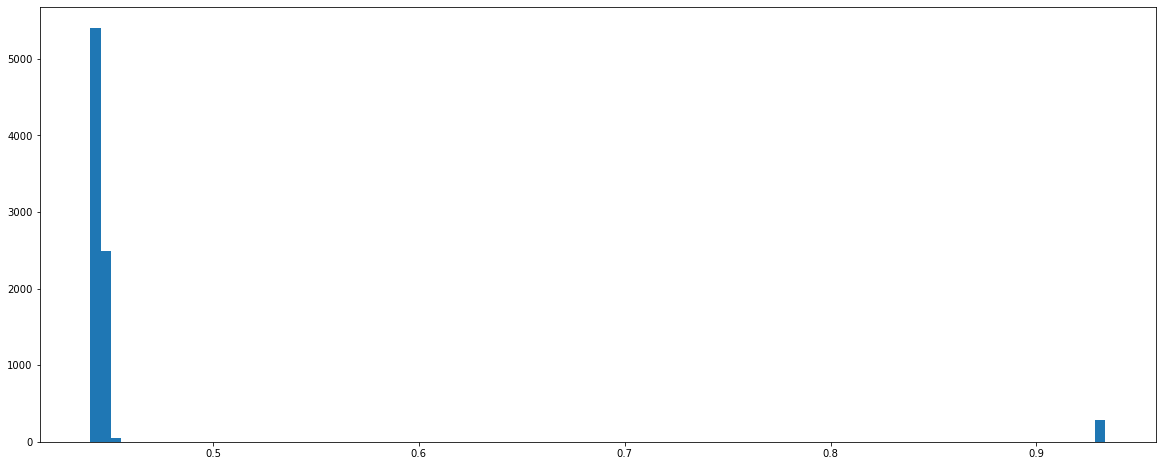

In [843]:
# Showing the distribution of probability of buying the deposit for each people

plt.figure(figsize=(20,8))
plt.hist(df_test['predict_proba LR 1'], bins=100)
plt.show()

In [844]:
# binning the probability of buying the deposit for each people

proba1_bin = [-1,0.3,0.6,df_test['predict_proba LR 1'].max()]
label_proba1 = ['< 0.3', '0.3 - 0.6', '> 0.6']
df_test['proba1_bin'] = pd.cut(df_test['predict_proba LR 1'], bins=proba1_bin, labels=label_proba1)

In [845]:
df_test.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,y_predict LR,predict_proba LR 0,predict_proba LR 1,proba1_bin
0,32,management,divorced,5,no,no,no,cellular,jul,tue,...,1.4,93.918,-42.7,4.961,5228.1,0,0,0.556469,0.443531,0.3 - 0.6
1,37,unemployed,unknown,5,no,no,no,cellular,jun,tue,...,-2.9,92.963,-40.8,1.262,5076.2,0,0,0.551559,0.448441,0.3 - 0.6
2,73,retired,divorced,6,unknown,yes,no,cellular,jul,thu,...,-1.7,94.215,-40.3,0.810,4991.6,0,0,0.552235,0.447765,0.3 - 0.6
3,44,entrepreneur,married,1,unknown,no,no,telephone,jun,tue,...,1.4,94.465,-41.8,4.961,5228.1,0,0,0.559124,0.440876,0.3 - 0.6
4,28,admin.,single,4,no,no,no,cellular,mar,fri,...,-1.8,92.843,-50.0,1.531,5099.1,0,0,0.552116,0.447884,0.3 - 0.6


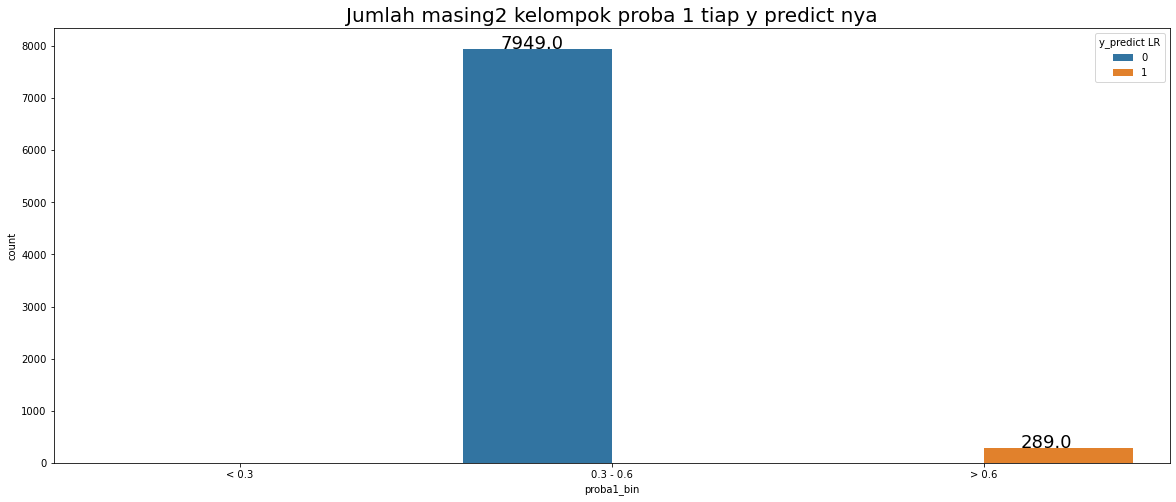

In [847]:
plt.figure(figsize=(20,8))
ax = sns.countplot(x="proba1_bin", hue="y_predict LR", data=df_test)
ax.set_title('Jumlah masing2 kelompok proba 1 tiap y predict nya', fontsize=20)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+.1, p.get_height()), 
                size=18
               )
plt.show()

In [835]:
# del df_test

__all_data__

In [669]:
# create the table/dataframe for all data

df_all = pd.concat([X, y], axis=1)
df_all = df_all.reset_index()
df_all = df_all.drop(columns=['index'])

In [670]:
# predict the probability of one person to take the deposit or not

y_all_predictproba = LR_Tune2.predict_proba(X)

In [671]:
# predict all people (in test data) that gonna take the deposit or not

y_all_predict = LR_Tune2.predict(X)

In [672]:
# input the data to df_all

df_all['y_predict LR'] = y_all_predict # create new column for y predict
df_all_predictproba = pd.DataFrame(y_all_predictproba) # create new dataframe for prediction of the probability
df_all_predictproba = df_all_predictproba.rename(columns={0: "predict_proba LR 0", 1: "predict_proba LR 1"})

In [673]:
# Combine df_all with df that contain prediction of the probability

df_all = pd.concat([df_all, df_all_predictproba], axis=1)

In [674]:
# showing confusion matrix

pd.crosstab(index=df_all['y'], columns = df_all['y_predict LR'])

y_predict LR,0,1
y,,
0,36000,548
1,3673,967


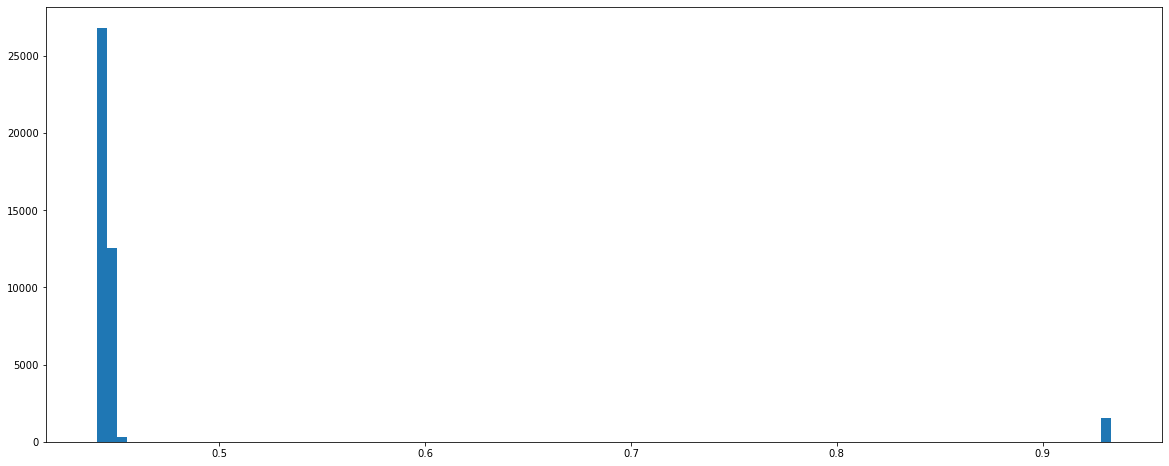

In [955]:
# Showing the distribution of probability of buying the deposit for each people

plt.figure(figsize=(20,8))
plt.hist(df_all['predict_proba LR 1'], bins=100)
plt.show()

In [677]:
# binning the probability of buying the deposit for each people

proba1_bin = [-1,0.3,0.6,df_all['predict_proba LR 1'].max()]
label_proba1 = ['< 0.3', '0.3 - 0.6', '> 0.6']
df_all['proba1_bin'] = pd.cut(df_all['predict_proba LR 1'], bins=proba1_bin, labels=label_proba1)

In [678]:
df_all.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,y_predict LR,predict_proba LR 0,predict_proba LR 1,proba1_bin
0,56,housemaid,married,1,no,no,no,telephone,may,mon,...,1.1,93.994,-36.4,4.857,5191.0,0,0,0.557911,0.442089,0.3 - 0.6
1,57,services,married,4,unknown,no,no,telephone,may,mon,...,1.1,93.994,-36.4,4.857,5191.0,0,0,0.558424,0.441576,0.3 - 0.6
2,37,services,married,4,no,yes,no,telephone,may,mon,...,1.1,93.994,-36.4,4.857,5191.0,0,0,0.557789,0.442211,0.3 - 0.6
3,40,admin.,married,2,no,no,no,telephone,may,mon,...,1.1,93.994,-36.4,4.857,5191.0,0,0,0.557817,0.442183,0.3 - 0.6
4,56,services,married,4,no,no,yes,telephone,may,mon,...,1.1,93.994,-36.4,4.857,5191.0,0,0,0.557739,0.442261,0.3 - 0.6


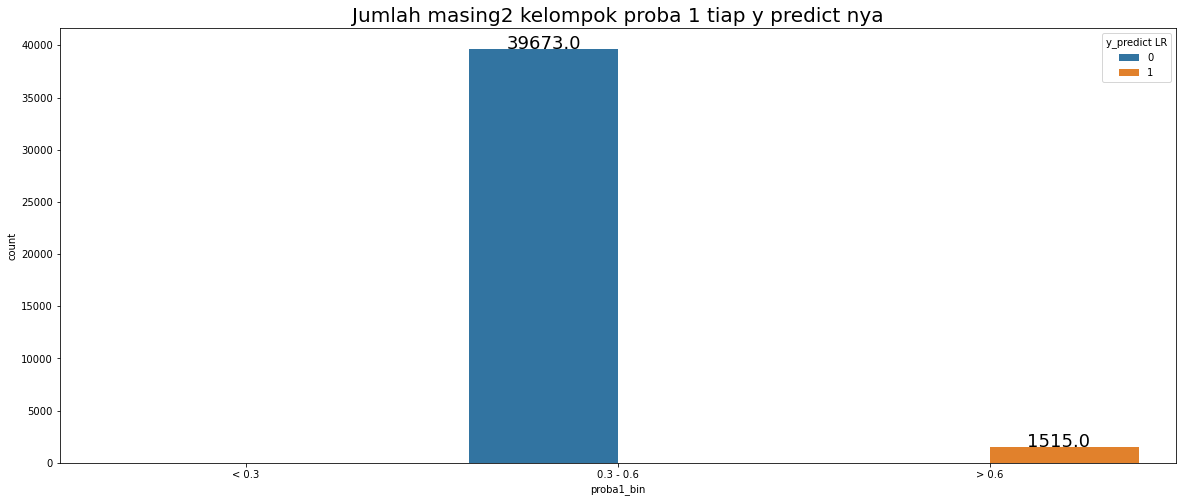

In [692]:
plt.figure(figsize=(20,8))
ax = sns.countplot(x="proba1_bin", hue="y_predict LR", data=df_all)
ax.set_title('Jumlah masing2 kelompok proba 1 tiap y predict nya', fontsize=20)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+.1, p.get_height()), 
                size=18
               )
plt.show()

In [681]:
# del df_all

_______________
__Simulation__
_______________

___1st SIMULATION (SUM DURATION APPROACH)___

__Assume__ : 
- all df data is new data
- Cost driven by two main things : __Call Charges per Minutes__, __Salary__
- The campaign duration is can be adjust
- __call charges__ : 0.3 euro per minutes
https://www.lonelyplanet.com/portugal/narratives/practical-information/directory/telephone#:~:text=Local%2C%20Regional%20%26%20National%20Calls&text=Local%20calls%20cost%20around%20%E2%82%AC,from%20anywhere%20in%20the%20country.

- __Salary__ : 1600 euro/person/month
http://www.salaryexplorer.com/salary-survey.php?loc=174&loctype=1&job=12702&jobtype=3

- 4 hours/240 minutes of call that can handled by 1 employee per day 

### After Modelling

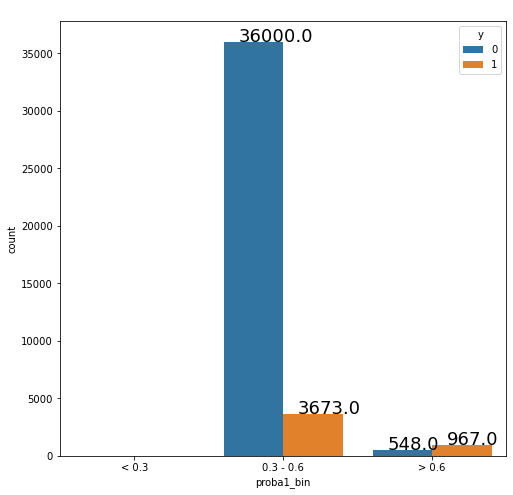

In [956]:
plt.figure(figsize=(8,8))
ax = sns.countplot(x="proba1_bin", hue="y", data=df_all)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+.1, p.get_height()), 
                size=18
               )
plt.show()

Based on the model simulation (thershold :0.3 and 0.6) :
- people that have probability to buy a deposit < 0.3 = 0
- people that have probability to buy a deposit between 0.3 & 0.6 = 39673
- people that have probability to buy a deposit > 0.6 = 1515

If we assume for people that have bank account more than 30,000 Euro (from total people that have probability to buy a deposit between 0.3 & 0.6) is people that buy the deposit in actual (`df_all[(df_all['proba1_bin'] == '0.3 - 0.6') & (df_all['y'] == 1)]`)

### After Modelling

In [935]:
# total duration after modelling

df_all['duration'] = df['duration'] # adding column duration to df_all
td_after = (df_all[(df_all['proba1_bin'] == '0.3 - 0.6') & (df_all['y'] == 1)]['duration'].sum()) + df_all[(df_all['proba1_bin'] == '> 0.6')]['duration'].sum()
# extracting the sum of duration

td_after # show the duration after using the model

2698619

In [938]:
# employee needed after modelling

round(((td_after/(20*3) # find the duration per days from 20 working days per month if the project take 2 months to finish
       )/60 # convert the duration from second to minutes
      )/240 # if one person have onle 4 hours or 240 minutes time to do telemarketing per day
      , 0) # round up the numbers into 0 digit after comma

3.0

In [939]:
data={
    'Price' :{
        'Call Charges' :  0.3, # 0.3 euro per minutes for call charges
        'Salary' : 1600 # 1600 euro per month per person for telemarketing salary
    },
    'Quantity' :{
        'Call Charges' :  1, #
        'Salary' : 3 # 3 employee for the campaign
    },
    'Frequency' : {
        'Call Charges' :  round(td_after/60, 2), # the duration of call (in minutes) that required after using the model
        'Salary' : 3 # 3 months to finish the campaign
    }
}

print('Table Cost simulation after modelling')
after1 = pd.DataFrame(data)
after1['total for all months'] = after1['Price']*after1['Quantity']*after1['Frequency'] # adding columns that contain total cost 
# that we needed for a certain sector in 2 months

total_after1 = {
    'Price': 'Total',
    'Quantity' : 'Total',
    'Frequency' : 'Total',
    'total for all months' : after1['total for all months'].sum()
} # make new dictionary that have he sum of total cost for all sector in 2 months

new_row1 = pd.Series(total_after1, name='Total') # make a series of the dict
after1 = after1.append(new_row1) # make a new row
after1

Table Cost simulation after modelling


,Price,Quantity,Frequency,total for all months
Call Charges,0.3,1,44977,13493.094
Salary,1600,3,3,14400.000
Total,Total,Total,Total,27893.094


### Before Modelling

In [957]:
# total duration before

(df_all['duration'].sum())/60

177304.05

In [941]:
# emp needed before

round(((df_all['duration'].sum()/(20*10) # find the duration per days from 20 working days per month if the project
        # take 10 months to finish
       )/60 # convert the duration from second to minutes
      )/240, # if one person have onle 4 hours or 240 minutes time to do telemarketing per day
      0) # round up the numbers into 0 digit after comma

4.0

In [958]:
data2={
    'Price' :{
        'Call Charges' :  0.3, # 0.3 euro per minutes for call charges
        'Salary' : 1600 # 1600 euro per month per person for telemarketing salary
    },
    'Quantity' :{
        'Call Charges' :  1, #
        'Salary' : 4 # 4 employee for the campaign
    },
    'Frequency' : {
        'Call Charges' :  (df_all['duration'].sum())/60, # the duration of call (in minutes) that required Before using the model
        'Salary' : 10 # 10 months to finish the campaign
    }
}

print('Table Cost simulation before modelling')
before1 = pd.DataFrame(data2)
before1['total for all months'] = before1['Price']*before1['Quantity']*before1['Frequency']# adding columns that contain
# total cost that we needed for a certain sector in 2 months

total_before1 = {
    'Price': 'Total',
    'Quantity' : 'Total',
    'Frequency' : 'Total',
    'total for all months' : before1['total for all months'].sum()
}# make new dictionary that have he sum of total cost for all sector in 10 months

new_row2 = pd.Series(total_before1, name='Total')# make a series of the dict
before1 = before1.append(new_row2)# make a new row
before1

Table Cost simulation before modelling


,Price,Quantity,Frequency,total for all months
Call Charges,0.3,1,177304,53191.215
Salary,1600,4,10,64000.000
Total,Total,Total,Total,117191.215


### Combined the Simulation Table Before and After Modelling

In [959]:
result1 = pd.concat([before1, after1], keys=["Before", "After"])
result1

Price Quantity Frequency  total for all months
Before Call Charges    0.3        1    177304             53191.215
       Salary         1600        4        10             64000.000
       Total         Total    Total     Total            117191.215
After  Call Charges    0.3        1     44977             13493.094
       Salary         1600        3         3             14400.000
       Total         Total    Total     Total             27893.094

In [960]:
saving1= result1.loc['Before', 'Total']['total for all months']-result1.loc['After', 'Total']['total for all months']
# extract the total cost before and after the modelling

string1 = f"Cost after using the model can be more efficient up to {saving1} euro saving," # show the amount of cost saving
string2 = f"{round((saving1/result1.loc['Before', 'Total']['total for all months'])*100, 2)}% decline" # show the cost reduction

print(string1, string2)

Cost after using the model can be more efficient up to 89298.121 euro saving, 76.2% decline


_______________
__Export Model__
_______________

In [970]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [953]:
# joblib.dump(LR_Tune2, 'Model_LR.jbl')